# Notes on an ARMA(1, 1) Model with NumPyro

## Prepare Notebook

In [1]:
from collections.abc import Callable

import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax import lax, random
from jaxlib.xla_extension import ArrayImpl
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from pydantic import BaseModel, Field
from statsmodels.tsa.arima.model import ARIMA

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Generate Data

### For-Loop Approach

In [2]:
n_samples = 100 + 1

phi = 0.4
theta = 0.7

noise_scale = 0.5


def generate_arma_1_1_data_for_loop(rng_key, n_samples, phi, theta, noise_scale):
    error = noise_scale * random.normal(rng_key, (n_samples,))

    y = jnp.zeros(n_samples)

    for t in range(1, y.size):
        ar_part = phi * y[t - 1]
        ma_part = theta * error[t - 1]
        y_t = ar_part + ma_part + error[t]
        y = y.at[t].set(y_t)  # noqa

    return y[1:]


y_foor_loop = generate_arma_1_1_data_for_loop(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

### Scan Approach

In [3]:
def generate_arma_1_1_data_scan(rng_key, n_samples, phi, theta, noise_scale):
    error = noise_scale * random.normal(rng_key, (n_samples,))

    def arma_step(carry, noise):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        y_t = ar_part + ma_part + noise
        return (y_t, noise), y_t

    init_carry = (0.0, error[0])
    _, y = lax.scan(arma_step, init_carry, error[1:])
    return y


y_scan = generate_arma_1_1_data_scan(
    rng_key=rng_key, n_samples=n_samples, phi=phi, theta=theta, noise_scale=noise_scale
)

In [4]:
jnp.allclose(y_foor_loop, y_scan, atol=1e-5)

Array(True, dtype=bool)

[Text(0.5, 0, 'time'), Text(0, 0.5, 'y'), Text(0.5, 1.0, 'Time Series Data')]

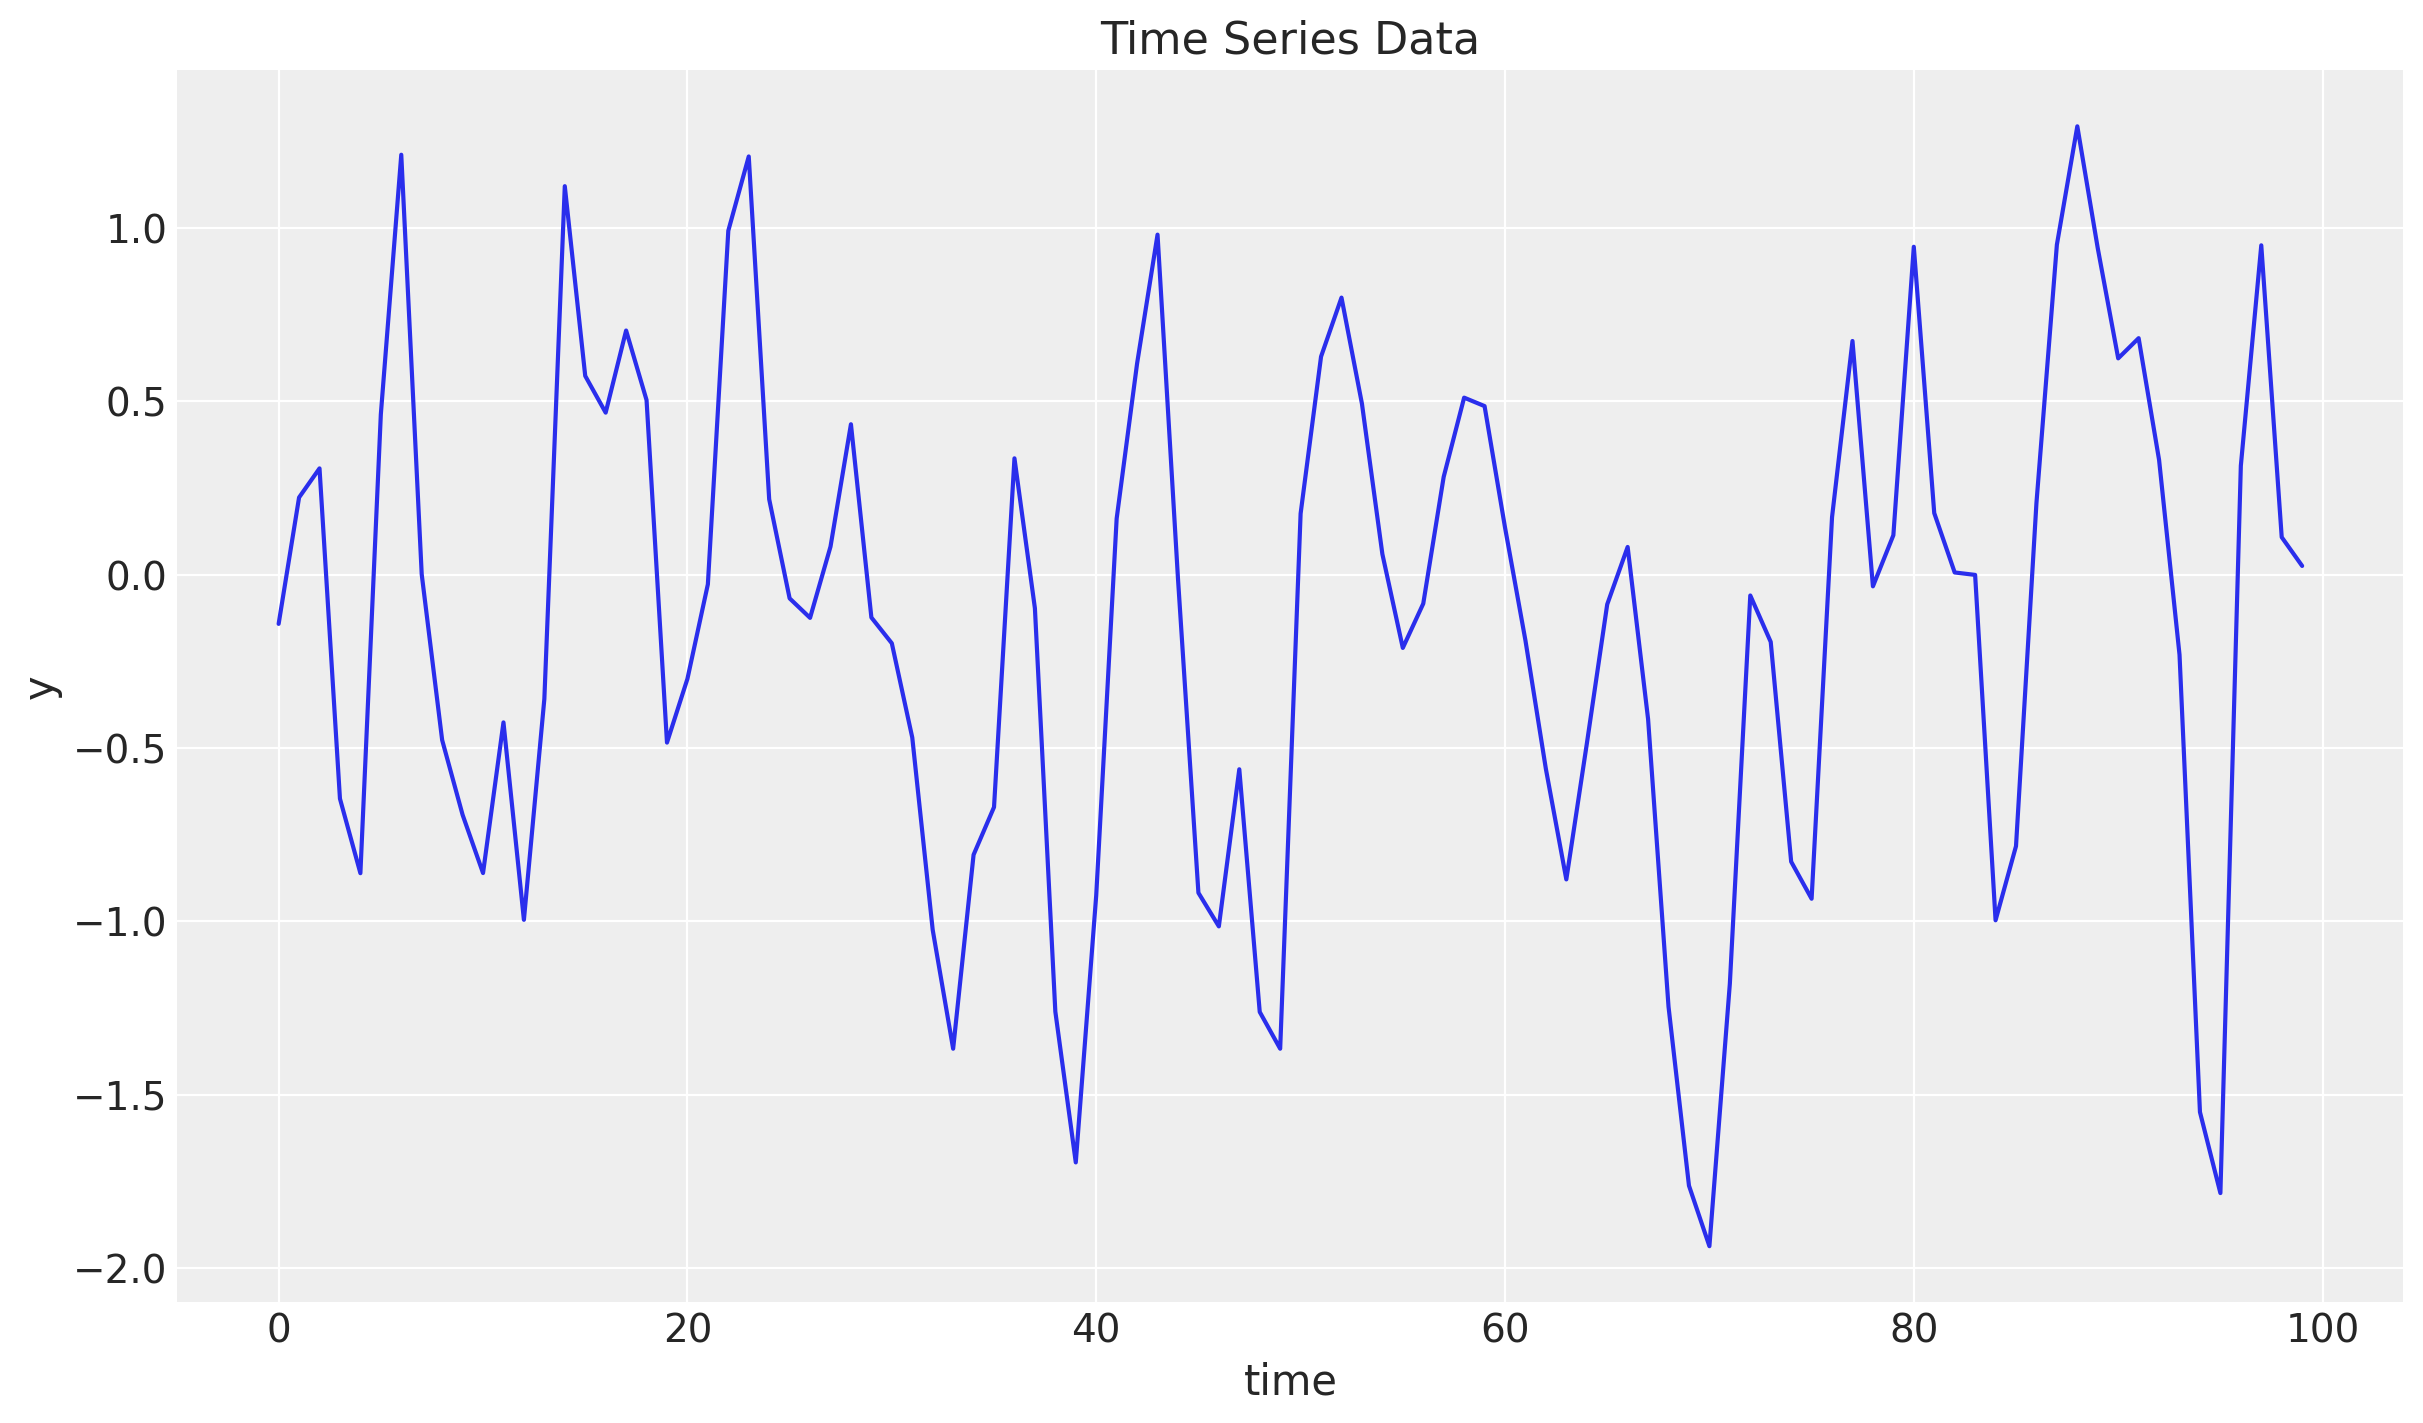

In [5]:
y = y_scan
t = jnp.arange(y.size)

fix, ax = plt.subplots()
ax.plot(t, y)
ax.set(xlabel="time", ylabel="y", title="Time Series Data")

### Train-Test Split

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'Time Series Data Split')]

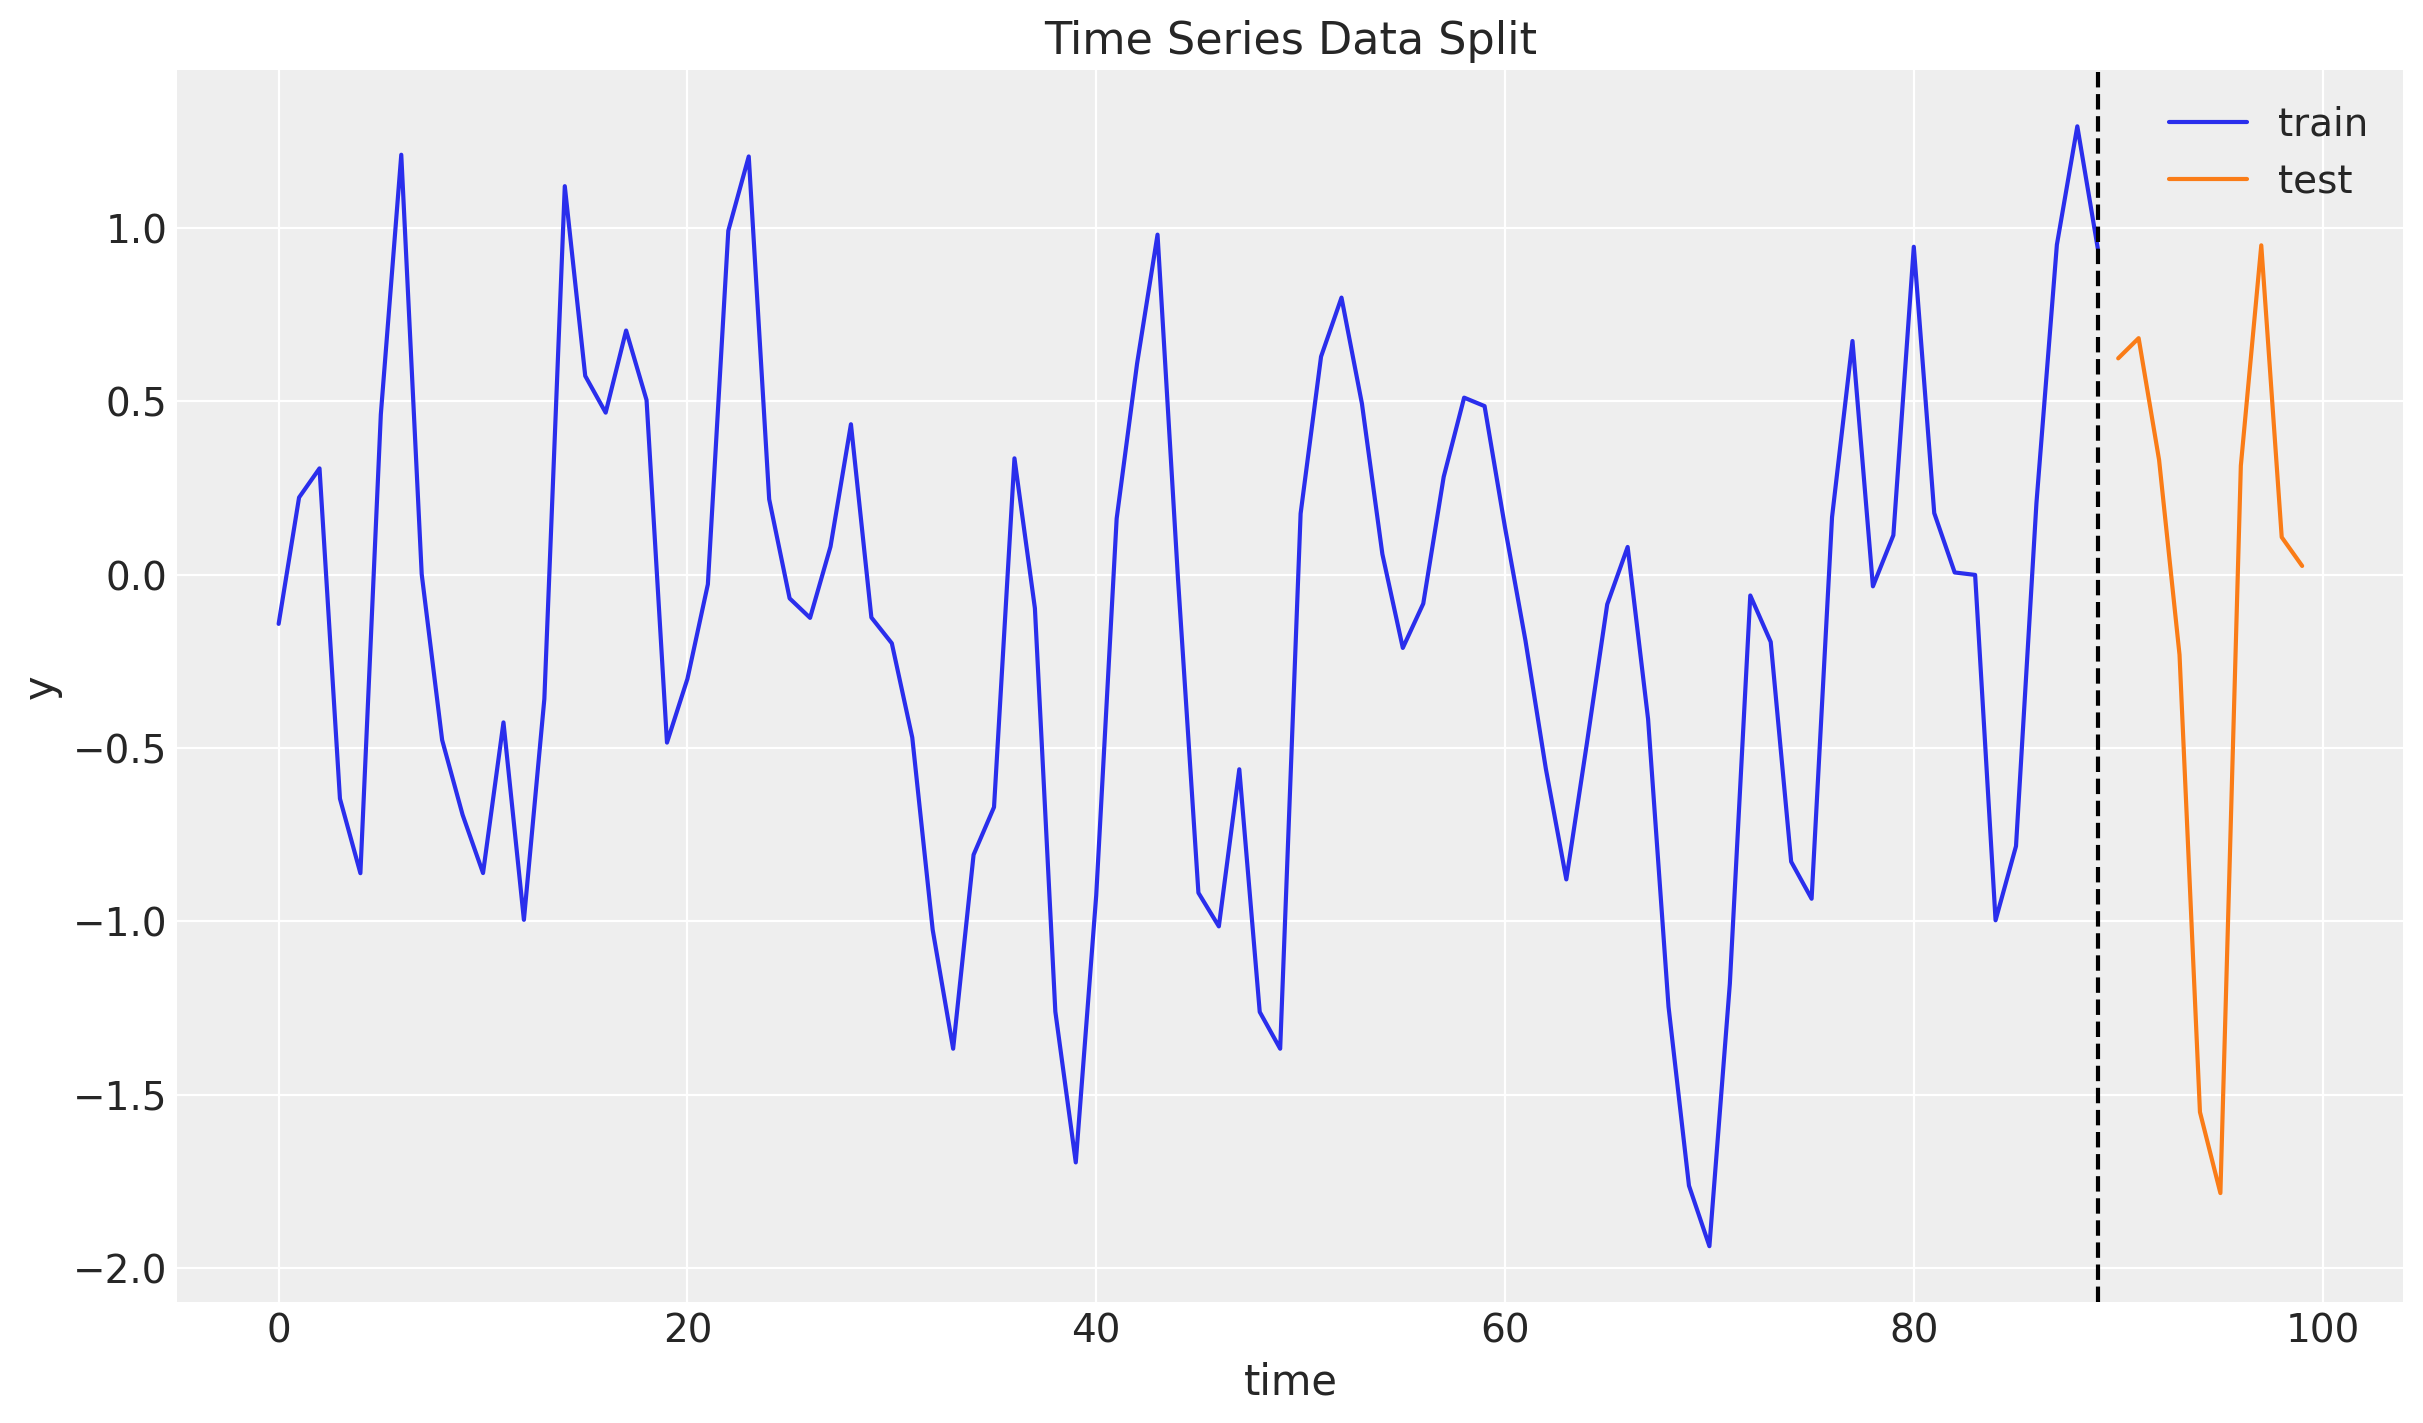

In [6]:
n = y.size

prop_train = 0.9
n_train = round(prop_train * n)

y_train = y[:n_train]
t_train = t[:n_train]

y_test = y[n_train:]
t_test = t[n_train:]

fig, ax = plt.subplots()
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="Time Series Data Split")

## ARMA Model: Statsmodels

In [7]:
model = ARIMA(np.asarray(y_train), order=(1, 0, 1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   90
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 -62.856
Date:                Mon, 12 Feb 2024   AIC                            133.711
Time:                        22:57:21   BIC                            143.711
Sample:                             0   HQIC                           137.744
                                 - 90                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1404      0.134     -1.046      0.296      -0.403       0.123
ar.L1          0.3512      0.115      3.042      0.002       0.125       0.577
ma.L1          0.6938      0.083      8.407      0.000       0.532       0.856
sigma2         0.2335      0.043      5.466      0.000       0.150       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 1.50
Prob(Q):                              0.70   Prob(JB):                         0.47
Heteroskedasticity (H):               0.82   Skew:                             0.04
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
forecast_df = result.get_forecast(steps=y_test.size).summary_frame(alpha=0.94)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast (Statsmodels)')]

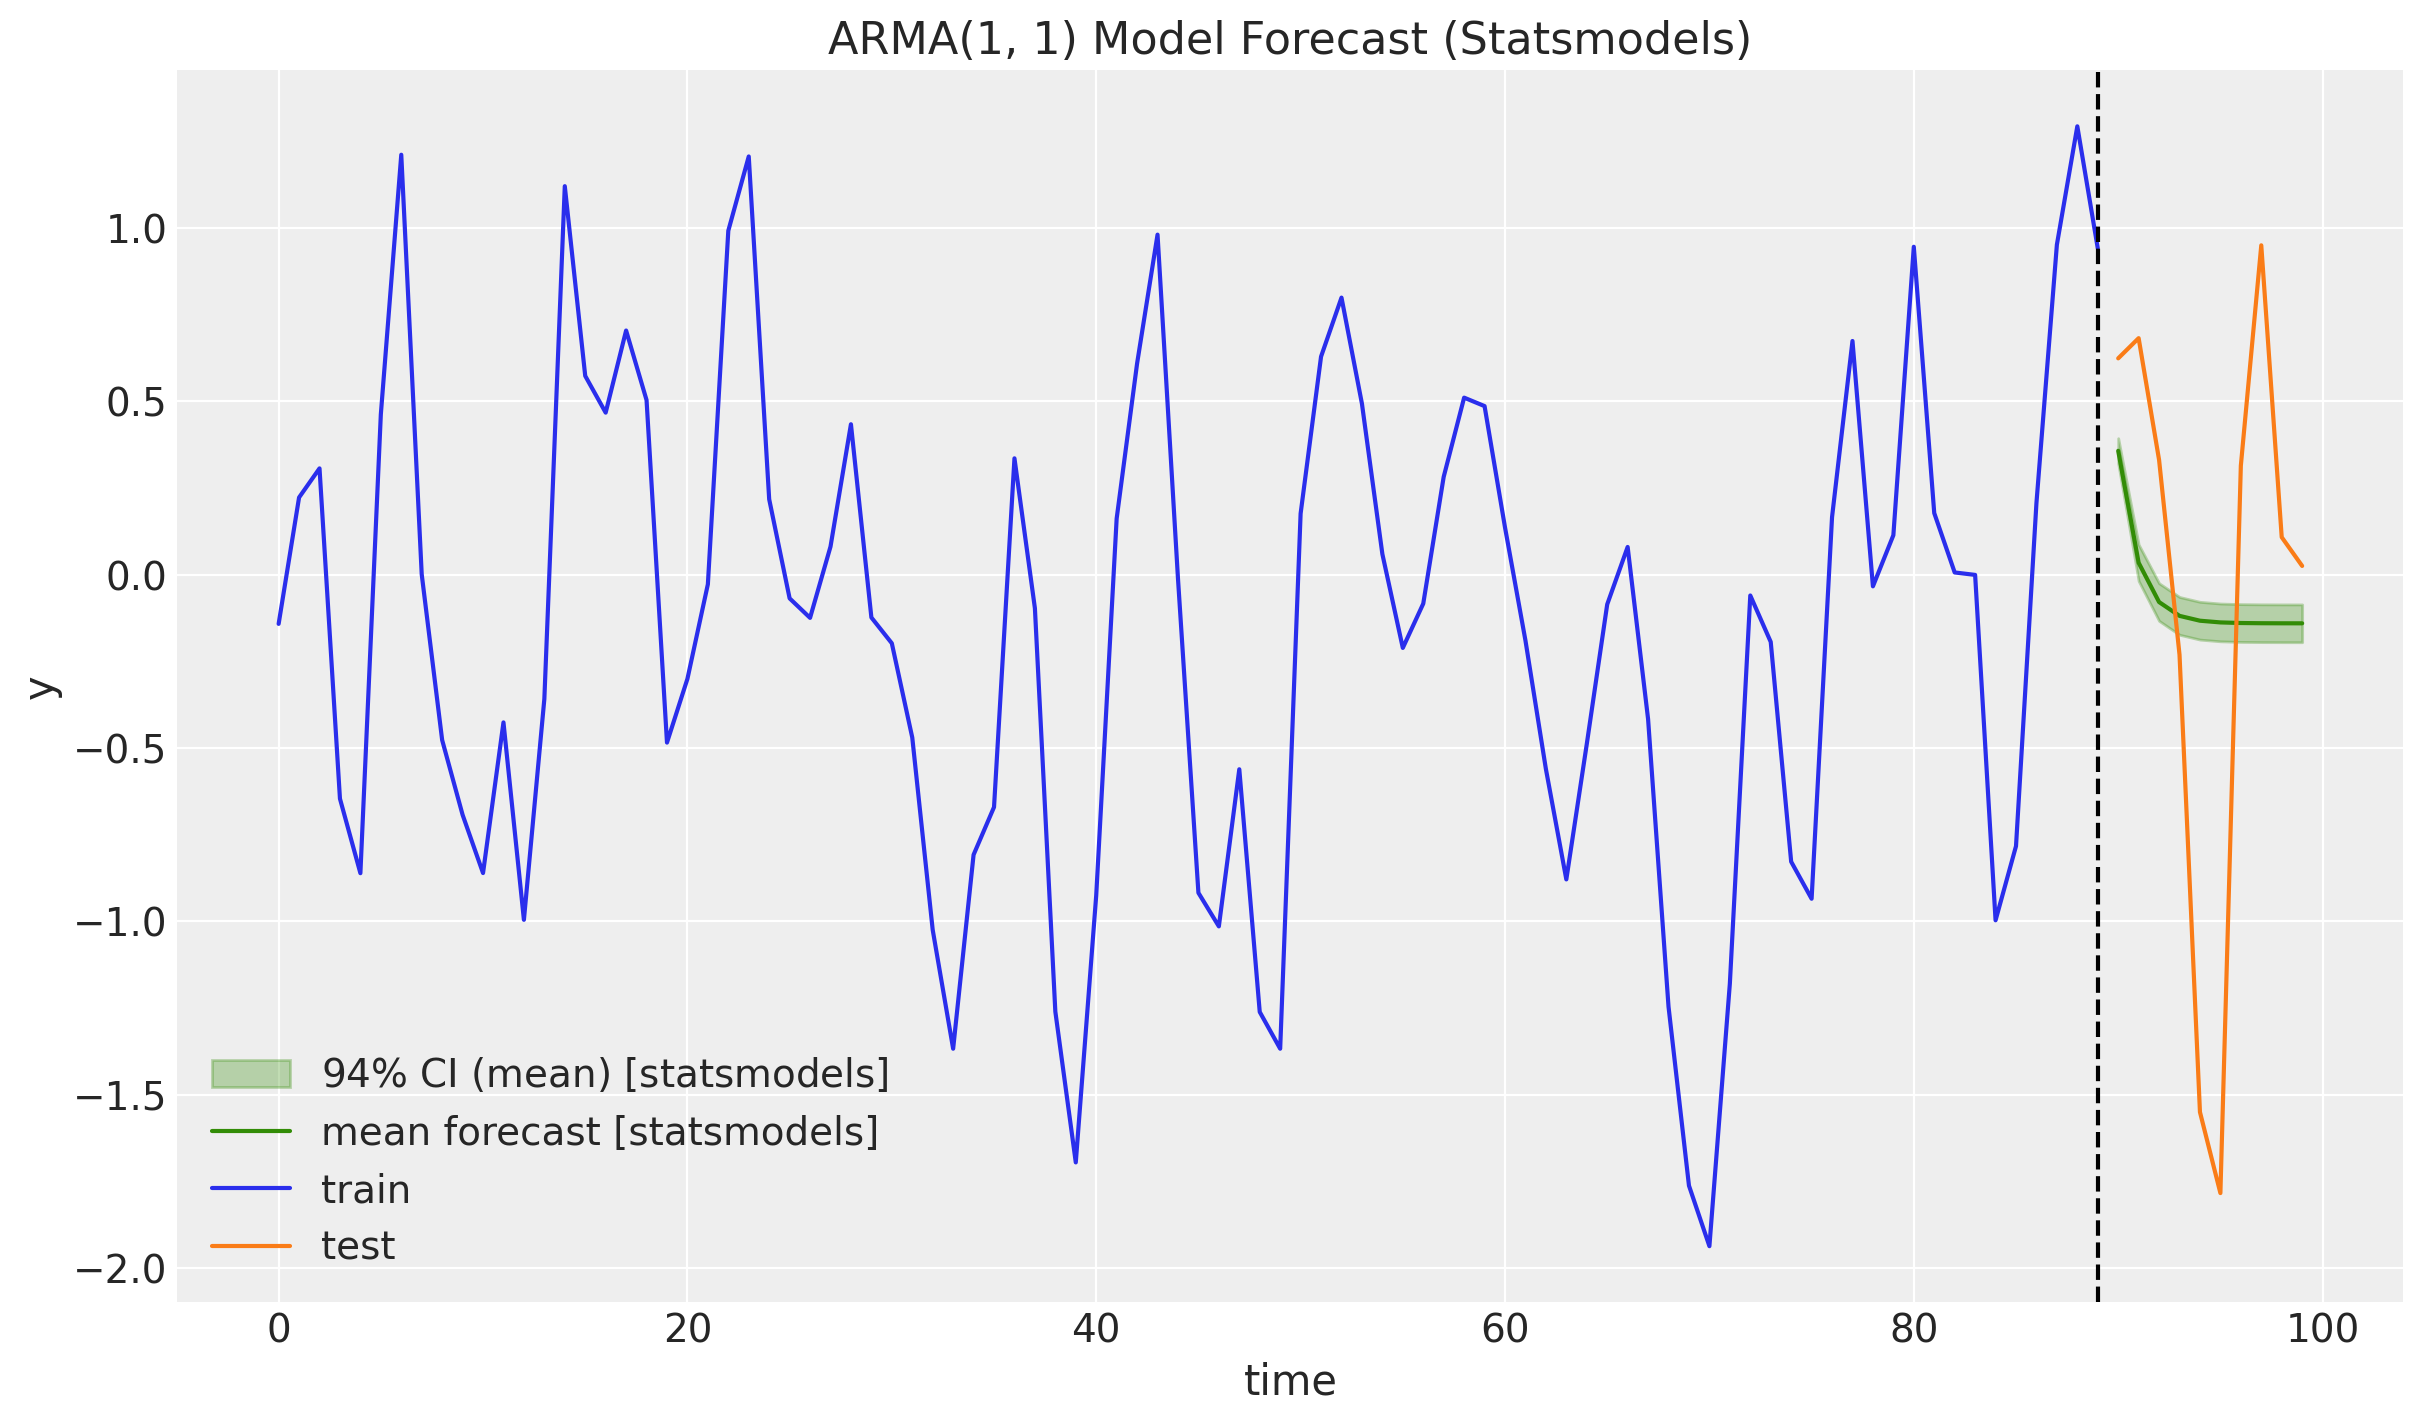

In [9]:
fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_df["mean"], color="C2", label="mean forecast [statsmodels]")
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast (Statsmodels)")

## NumPyro ARMA(1, 1) Model

### Model Specification

In [10]:
def arma_1_1(y: ArrayImpl, future: int = 0) -> None:
    mu = numpyro.sample("mu", dist.Uniform(low=-1, high=1))
    phi = numpyro.sample("phi", dist.Uniform(low=-1, high=1))
    theta = numpyro.sample("theta", dist.Uniform(low=-1, high=1))
    sigma = numpyro.sample("sigma", dist.HalfNormal(scale=1))

    def transition_fn(carry, t):
        y_prev, error_prev = carry
        ar_part = phi * y_prev
        ma_part = theta * error_prev
        pred = mu + ar_part + ma_part
        error = y[t] - pred
        return (y[t], error), error

    error_0 = y[0] - (mu + phi * mu)
    _, errors = scan(transition_fn, (y[0], error_0), jnp.arange(1, len(y) + future))

    errors = jnp.concat([error_0[None], errors])
    numpyro.sample("errors", dist.Normal(loc=0, scale=sigma), obs=errors)

    if future > 0:

        def prediction_fn(carry, _):
            y_prev, error_prev = carry
            ar_part = phi * y_prev
            ma_part = theta * error_prev
            pred = mu + ar_part + ma_part
            error = 0.0
            return (pred, error), pred

        _, y_forecast = scan(prediction_fn, (y[-1], errors[-1]), jnp.arange(future))
        numpyro.deterministic("y_forecast", y_forecast)

### Inference

In [11]:
class InferenceParams(BaseModel):
    num_warmup: int = Field(2_000, ge=1)
    num_samples: int = Field(2_000, ge=1)
    num_chains: int = Field(4, ge=1)


def run_inference(
    rng_key: ArrayImpl,
    model: Callable,
    args: InferenceParams,
    *model_args,
    **nuts_kwargs,
) -> MCMC:
    sampler = NUTS(model, **nuts_kwargs)
    mcmc = MCMC(
        sampler=sampler,
        num_warmup=args.num_warmup,
        num_samples=args.num_samples,
        num_chains=args.num_chains,
    )
    mcmc.run(rng_key, *model_args)
    return mcmc

In [12]:
inference_params = InferenceParams()
rng_key, rng_subkey = random.split(key=rng_key)
mcmc = run_inference(rng_subkey, arma_1_1, inference_params, y_train)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [13]:
idata = az.from_numpyro(posterior=mcmc)

az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.092,0.090,-0.276,0.066,0.001,0.001,7116.0,5515.0,1.0
phi,0.361,0.116,0.142,0.578,0.001,0.001,6299.0,5628.0,1.0
sigma,0.498,0.038,0.428,0.570,0.000,0.000,8066.0,5865.0,1.0
theta,0.678,0.083,0.524,0.826,0.001,0.001,6446.0,6181.0,1.0


In [14]:
print(f"""Divergences: {idata["sample_stats"]["diverging"].sum().item()}""")

Divergences: 0


Text(0.5, 0.98, 'Trace')

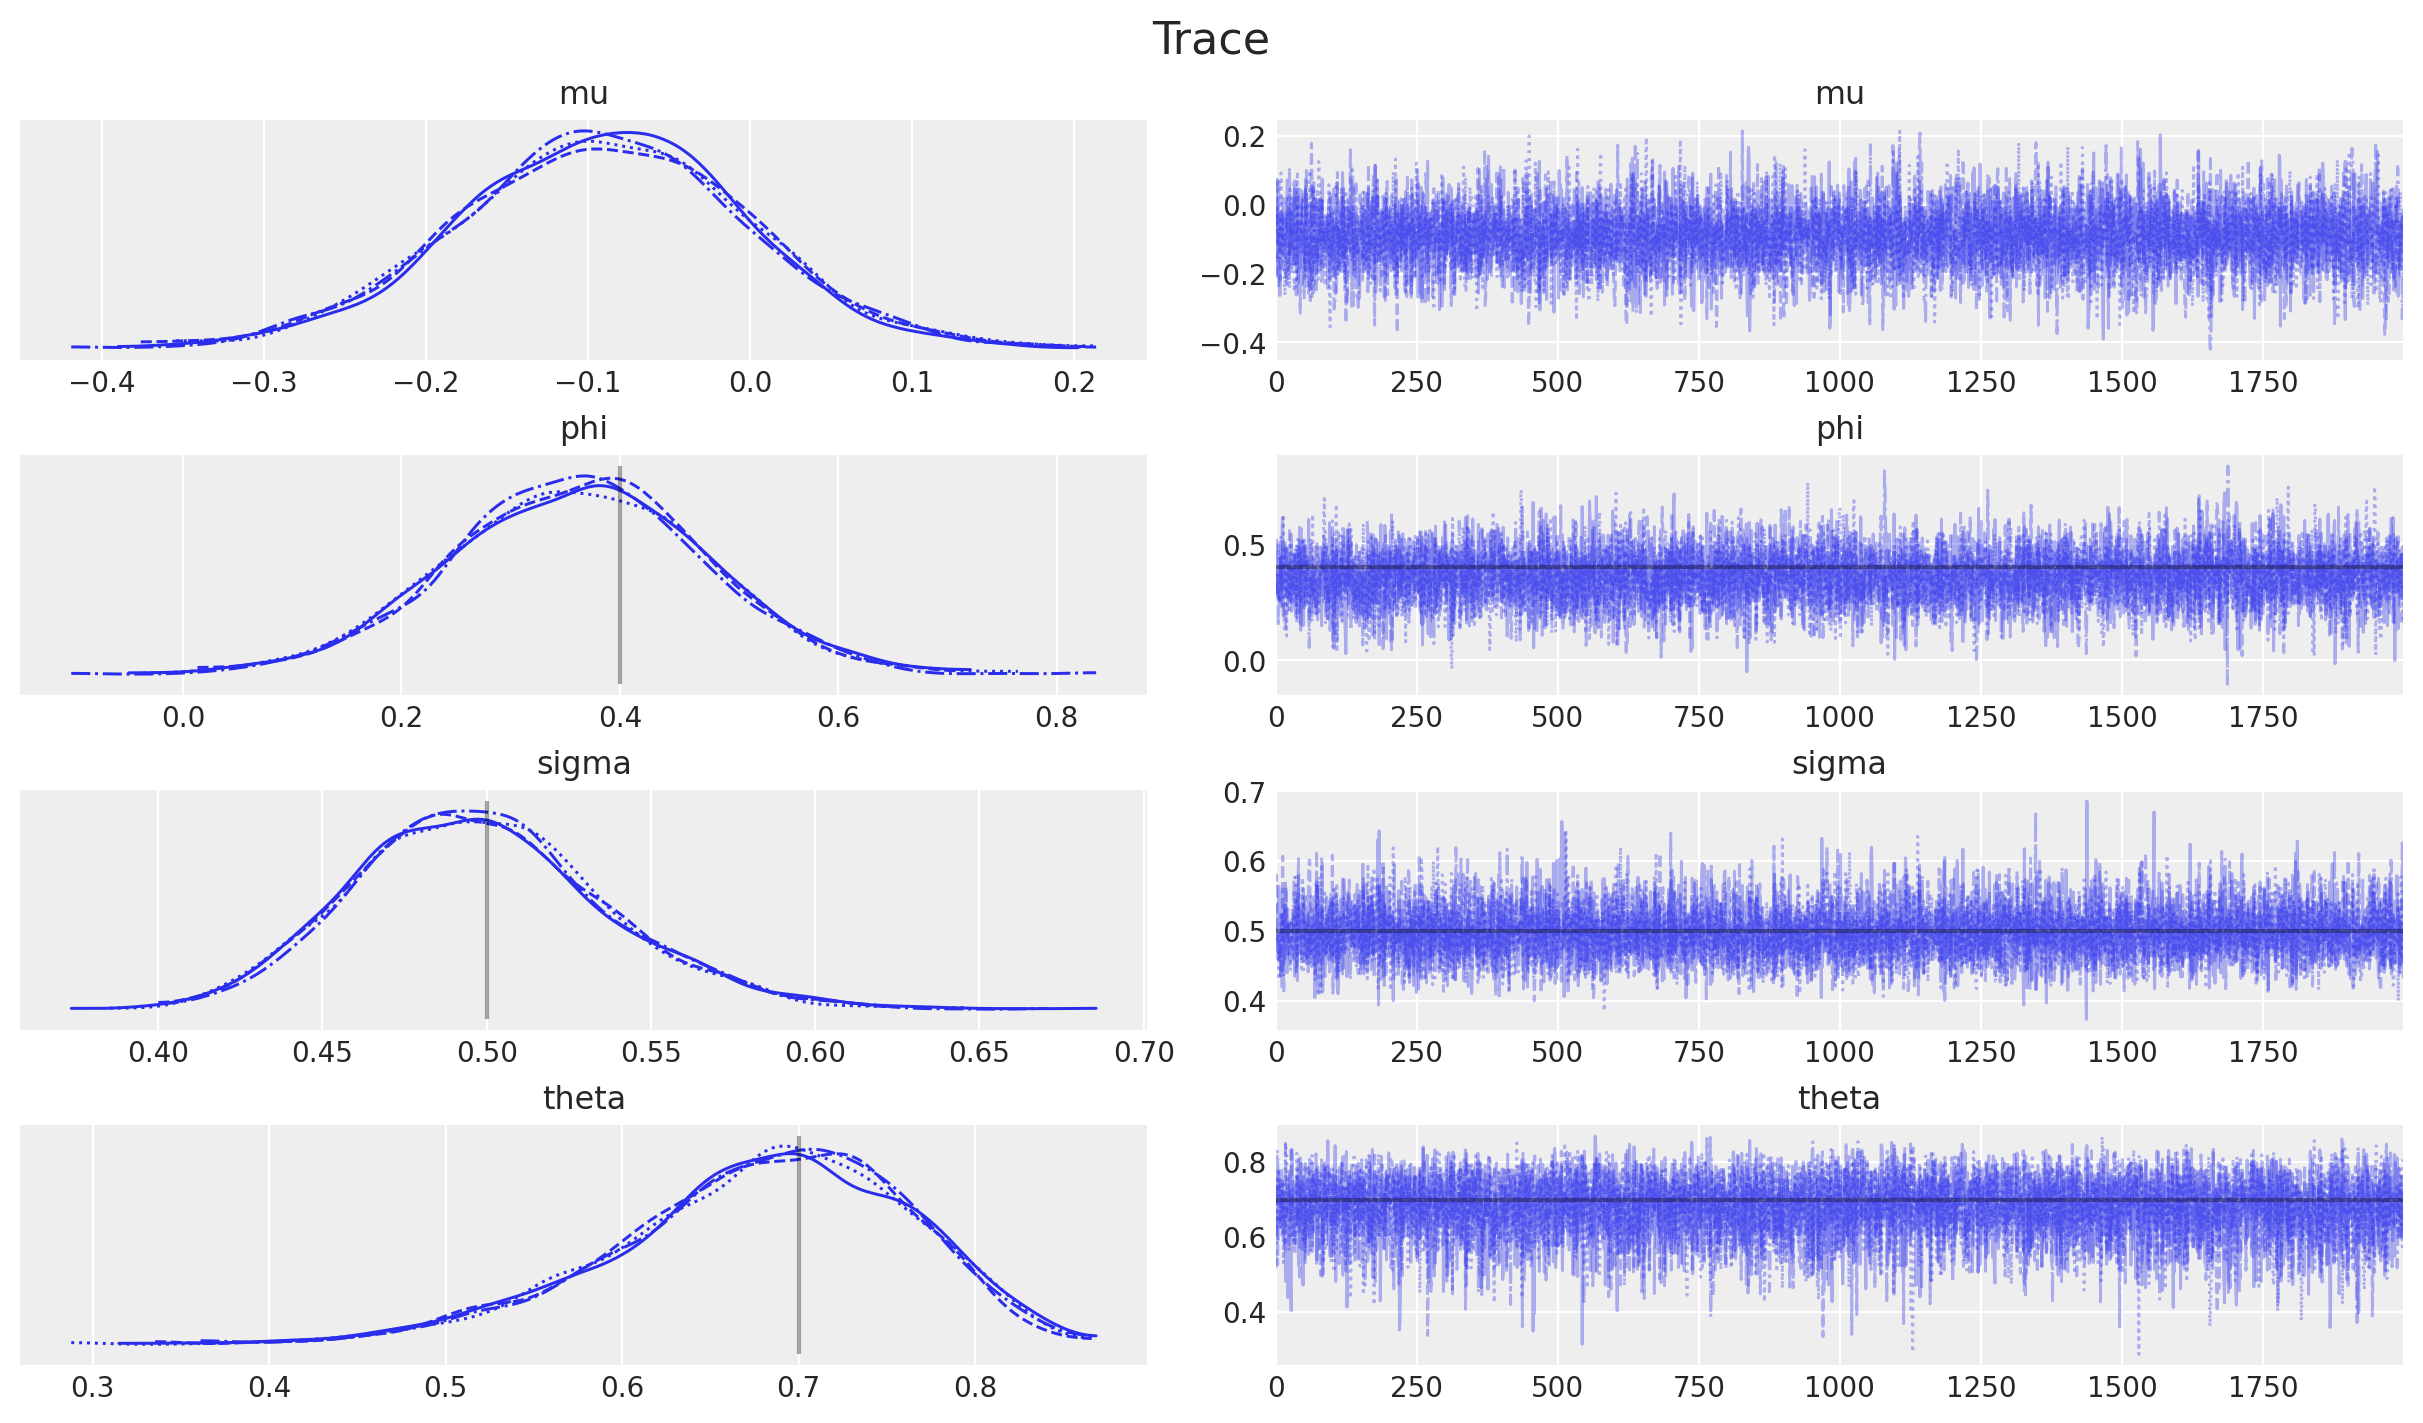

In [15]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    lines=[("phi", {}, phi), ("theta", {}, theta), ("sigma", {}, noise_scale)],
    backend_kwargs={"figsize": (12, 7), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16)

### Forecasting

In [16]:
def forecast(
    rng_key: ArrayImpl, model: Callable, samples: dict[str, ArrayImpl], *model_args
) -> dict[str, ArrayImpl]:
    predictive = Predictive(
        model=model,
        posterior_samples=samples,
        return_sites=["y_forecast", "errors"],
    )
    return predictive(rng_key, *model_args)

In [17]:
rng_key, rng_subkey = random.split(key=rng_key)
forecast = forecast(rng_subkey, arma_1_1, mcmc.get_samples(), y_train, y_test.size)

In [18]:
posterior_predictive = az.from_numpyro(
    posterior_predictive=forecast,
    coords={"t_test": t_test, "t": t},
    dims={"y_forecast": ["t_test"], "errors": ["t"]},
)

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast')]

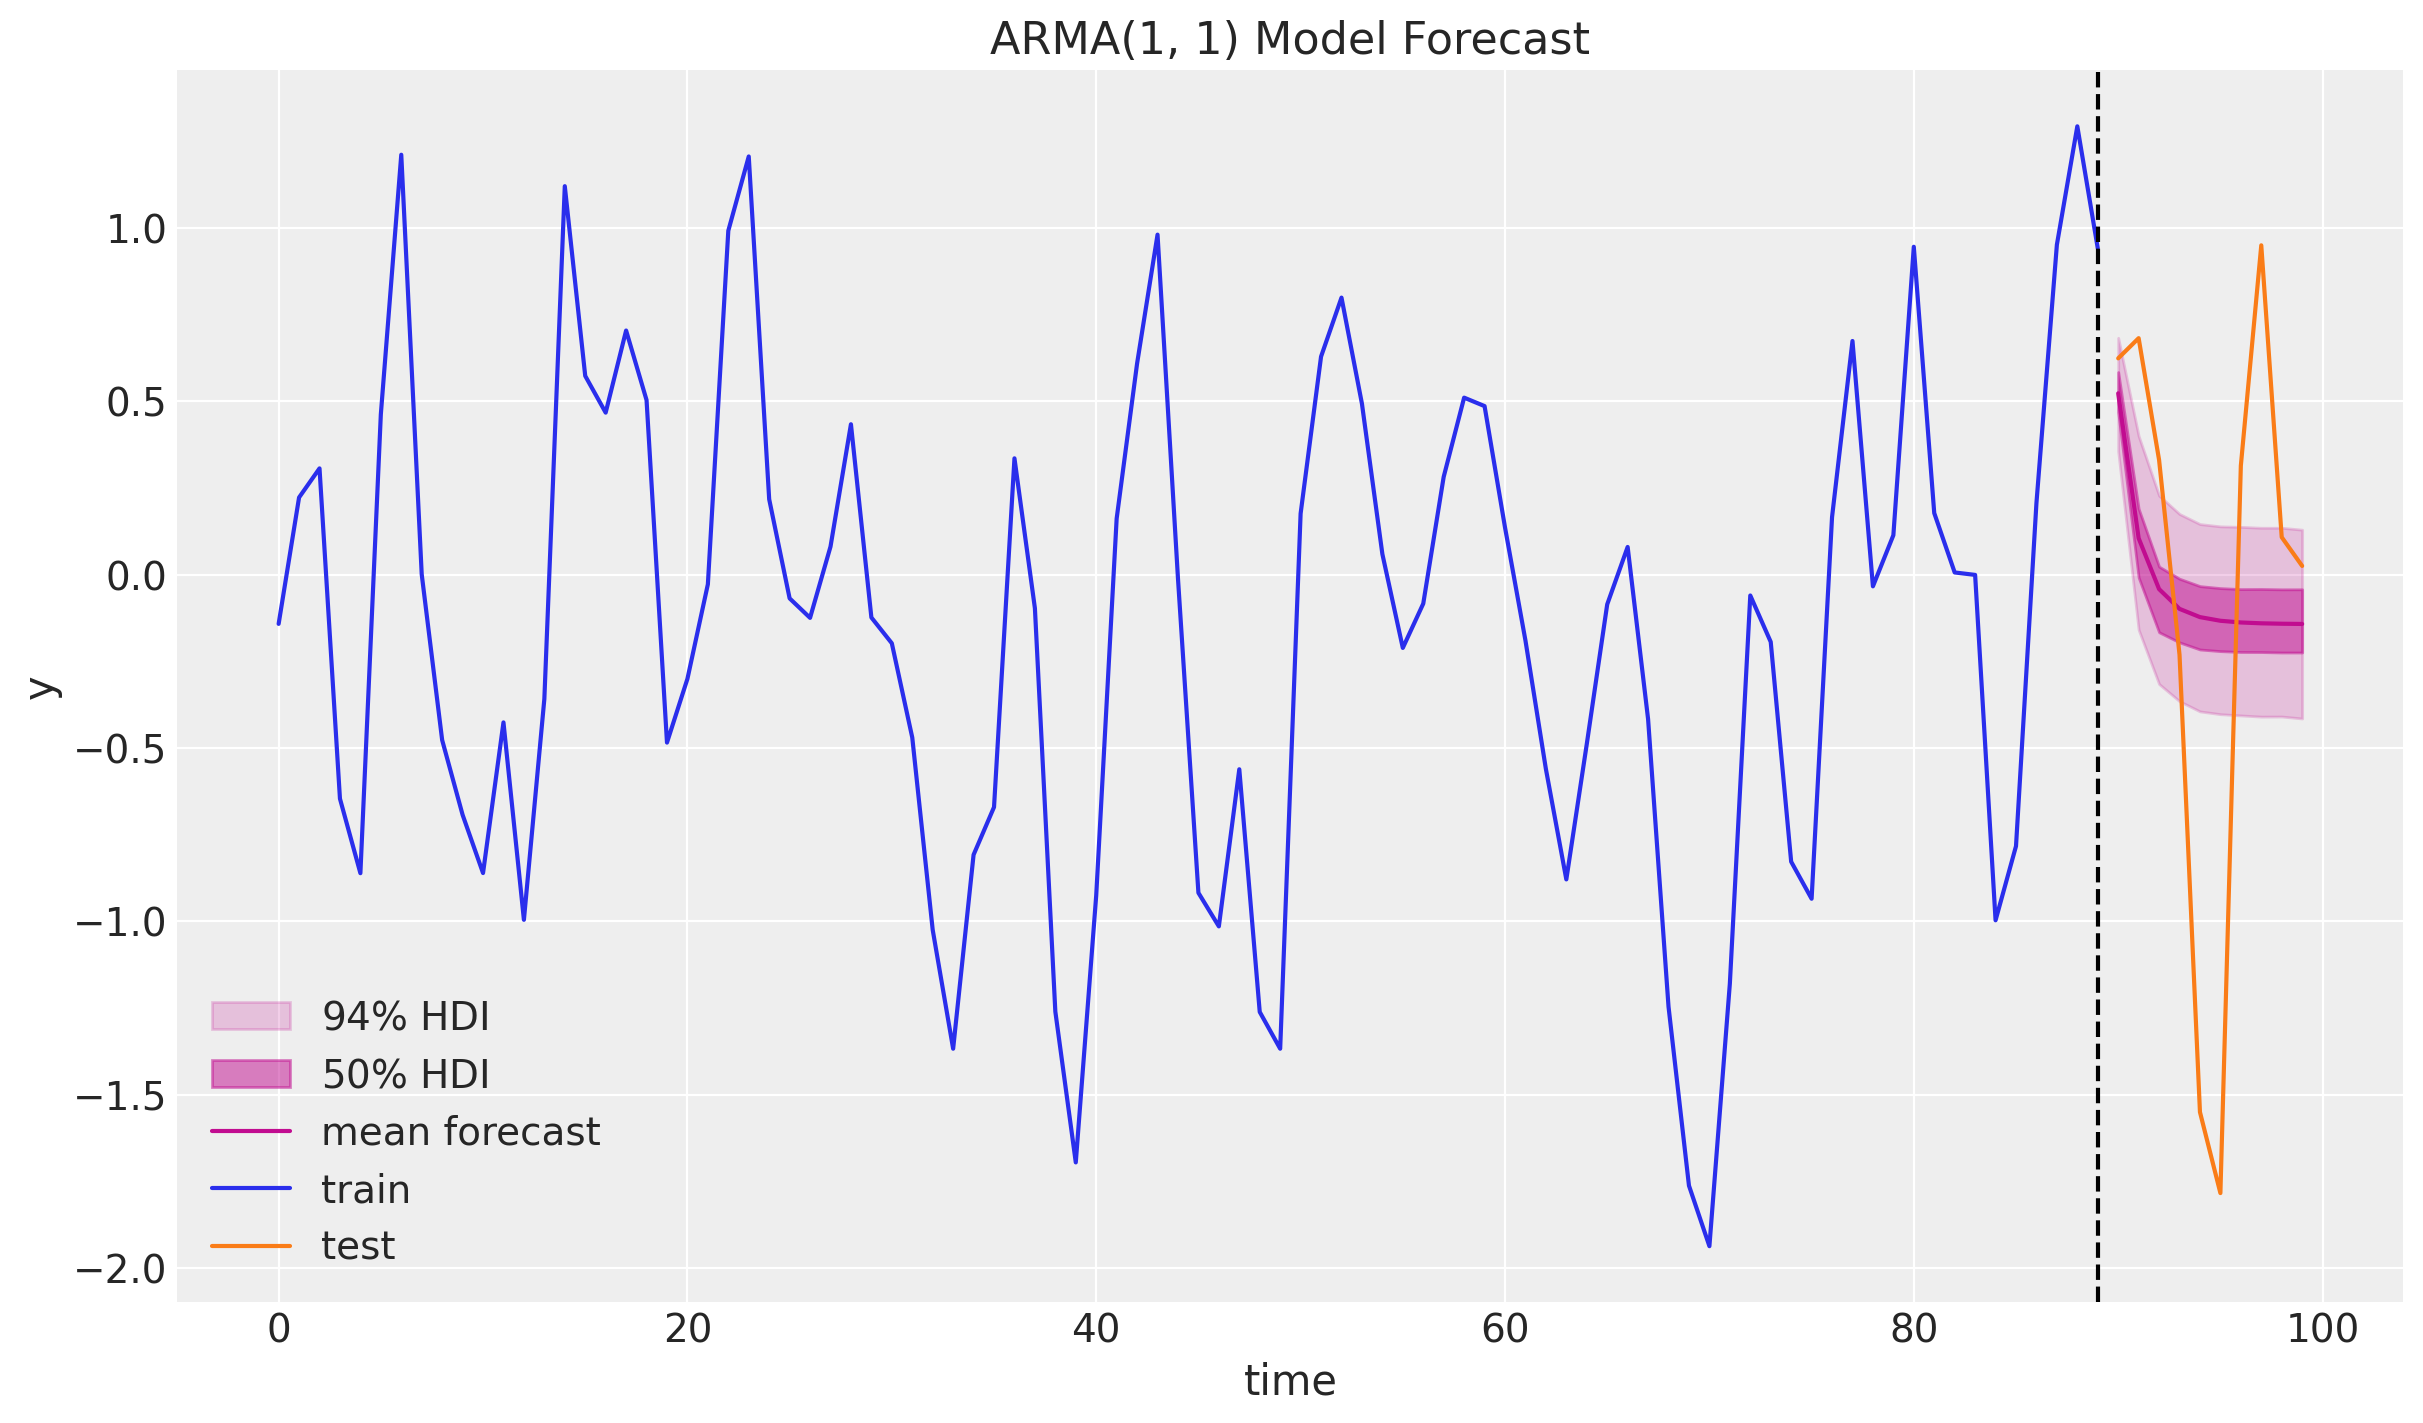

In [19]:
fig, ax = plt.subplots()
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.2, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend()
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast")

## Model Comparison

[Text(0.5, 0, 'time'),
 Text(0, 0.5, 'y'),
 Text(0.5, 1.0, 'ARMA(1, 1) Model Forecast - Model Comparison')]

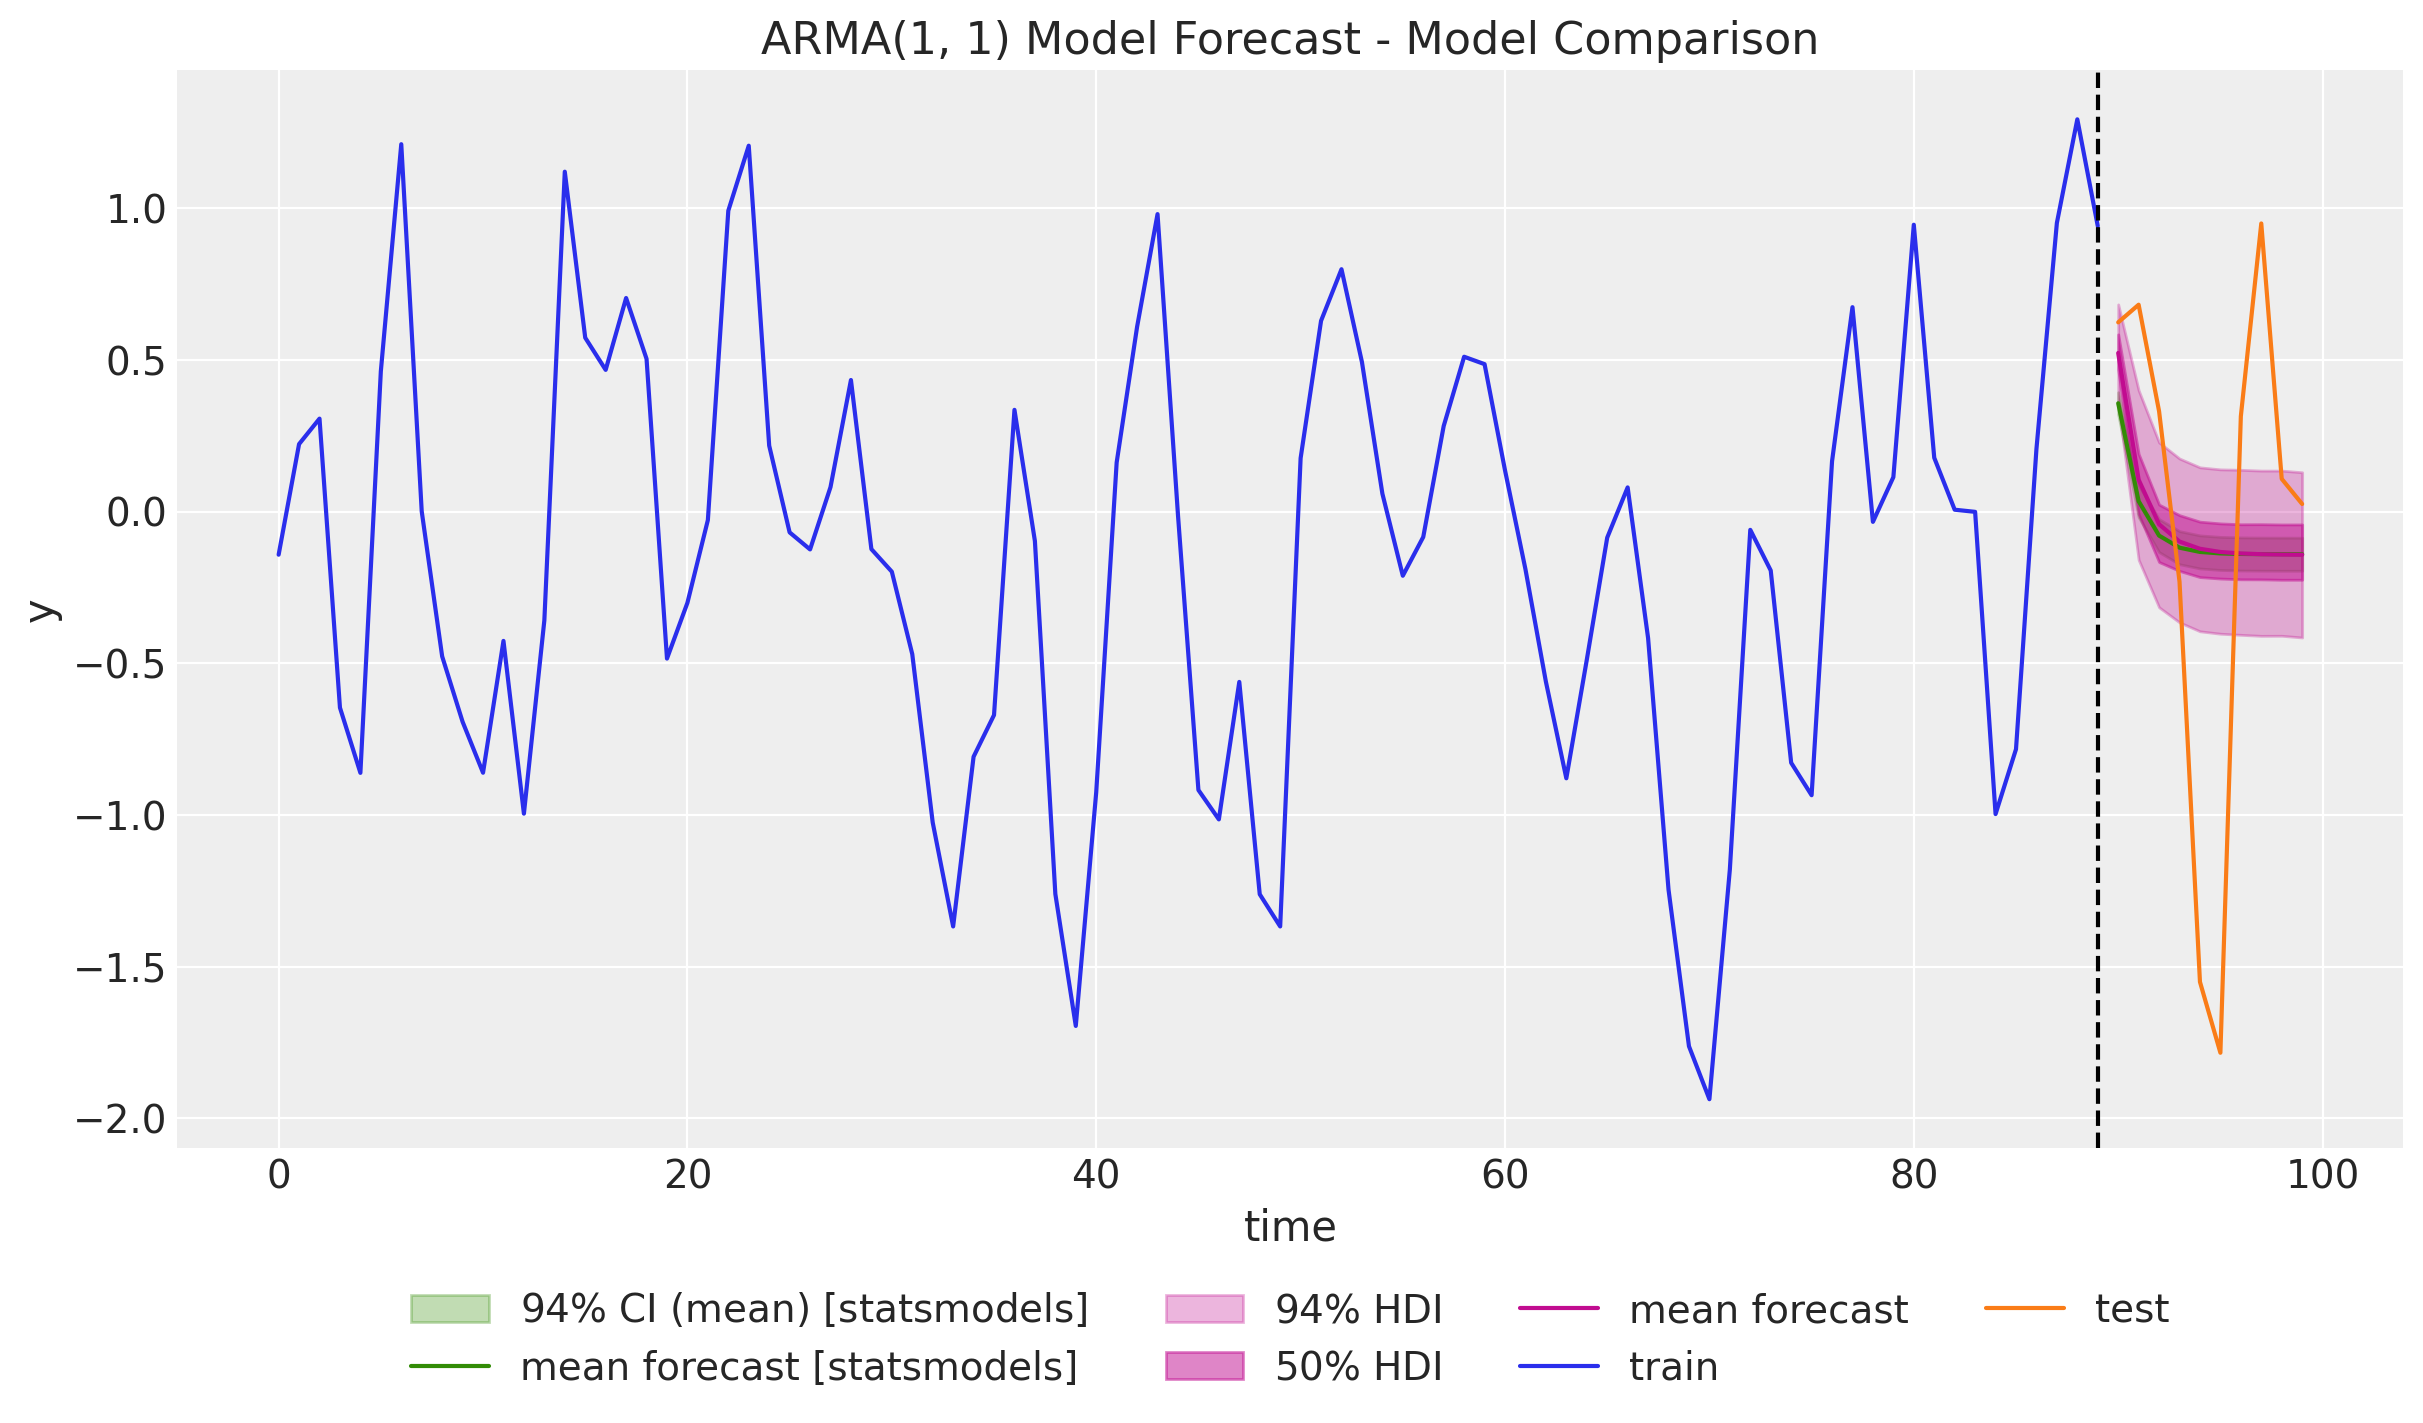

In [20]:
fig, ax = plt.subplots()
ax.fill_between(
    t_test,
    forecast_df["mean_ci_lower"],
    forecast_df["mean_ci_upper"],
    color="C2",
    alpha=0.3,
    label=r"$94\%$ CI (mean) [statsmodels]",
)
ax.plot(t_test, forecast_df["mean"], color="C2", label="mean forecast [statsmodels]")
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.94,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.3, "label": r"$94\%$ HDI"},
    ax=ax,
)
az.plot_hdi(
    x=t_test,
    y=posterior_predictive["posterior_predictive"]["y_forecast"],
    hdi_prob=0.50,
    color="C3",
    smooth=False,
    fill_kwargs={"alpha": 0.5, "label": r"$50\%$ HDI"},
    ax=ax,
)
ax.plot(
    t_test,
    posterior_predictive["posterior_predictive"]["y_forecast"].mean(
        dim=("chain", "draw")
    ),
    color="C3",
    label="mean forecast",
)
ax.plot(t_train, y_train, color="C0", label="train")
ax.plot(t_test, y_test, color="C1", label="test")
ax.axvline(x=t_train[-1], c="black", linestyle="--")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=4)
ax.set(xlabel="time", ylabel="y", title="ARMA(1, 1) Model Forecast - Model Comparison")